In [112]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import math

# visualizations
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics, preprocessing

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

KUMPULAN FUNGSI

In [113]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [114]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res['inv_'+str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [115]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [116]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')

INPUT DATA

In [117]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'
print(dataTA.shape) 
dataTA.head()

(120, 4)


,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-01-01,436.0,23.06,77.55,2.80
2012-02-01,493.0,23.50,78.69,6.33
2012-03-01,519.0,23.50,74.48,5.33
2012-04-01,482.0,24.00,81.00,3.00
2012-05-01,573.0,23.60,77.23,6.75


In [118]:
data=dataTA[['KasusDBD', 'Tavg']]
data.columns = ['KasusDBD', 'Tavg']
data.shape

(120, 2)

PLOT DATA   

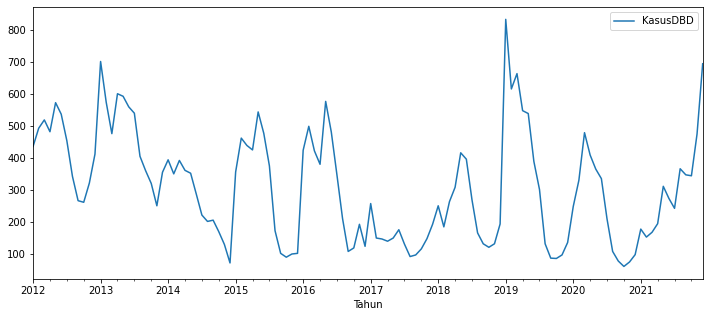

In [119]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)



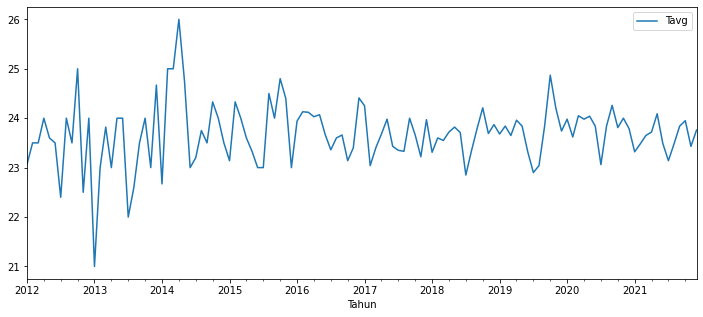

In [120]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['Tavg'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

UJI KORELASI

In [121]:
data.corr()

,KasusDBD,Tavg
KasusDBD,1.000000,-0.162691
Tavg,-0.162691,1.000000


UJI STASIONER

In [122]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Tavg
Test Statistic                  -3.634114
p-value                          0.005141
No Lags Used                    12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




NORMALISASI DATA

In [123]:
max_kasus = data['KasusDBD'].max()
max_suhu = data['Tavg'].max()

In [124]:
data['KasusDBD'] = data['KasusDBD']/max_kasus
data['Tavg'] = data['Tavg']/max_suhu
data

C:\Users\asus\AppData\Local\Temp\ipykernel_16368\3585945669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['KasusDBD'] = data['KasusDBD']/max_kasus
C:\Users\asus\AppData\Local\Temp\ipykernel_16368\3585945669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tavg'] = data['Tavg']/max_suhu


,KasusDBD,Tavg
Tahun,,
2012-01-01,0.522782,0.886923
2012-02-01,0.591127,0.903846
2012-03-01,0.622302,0.903846
2012-04-01,0.577938,0.923077
2012-05-01,0.687050,0.907692
...,...,...
2021-08-01,0.438849,0.903077
2021-09-01,0.416067,0.916923
2021-10-01,0.412470,0.921154


TRAIN TEST SPLIT AND DIFFERENCING

In [125]:
n = 3
train,test = data[0:-n], data[-n:]
train_diff=train.diff(periods=2)
train_diff.dropna(inplace=True)
train_diff

,KasusDBD,Tavg
Tahun,,
2012-03-01,0.099520,0.016923
2012-04-01,-0.013189,0.019231
2012-05-01,0.064748,0.003846
2012-06-01,0.065947,-0.019231
2012-07-01,-0.142686,-0.046154
...,...,...
2021-05-01,0.172662,0.016923
2021-06-01,0.094724,-0.008846
2021-07-01,-0.082734,-0.036538


In [126]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.200822
p-value                          0.000657
No Lags Used                    10.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Tavg
Test Statistic                  -3.953779
p-value                          0.001673
No Lags Used                    13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




In [127]:
cointegration_test(train_diff[['KasusDBD', 'Tavg']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KasusDBD >  90.44     > 12.3212   =>   True
Tavg   >  31.9      > 4.1296    =>   True


Text(0.5, 1.0, 'Partial Autocorrelation Function TAVG')

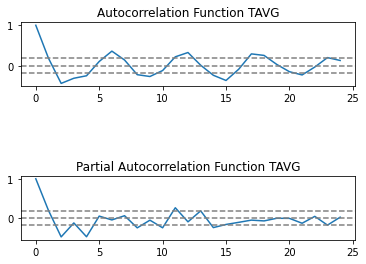

In [128]:
#TAVG
Tavg_acf = acf(train_diff['Tavg'], nlags=24)
Tavg_pacf = pacf(train_diff['Tavg'], nlags=24, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(Tavg_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['Tavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['Tavg'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function TAVG')

#Plot PACF:
plt.subplot(313)
plt.plot(Tavg_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['Tavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['Tavg'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function TAVG')

AUTO ARIMA

In [129]:
pq = []
for name, column in train_diff[['KasusDBD','Tavg']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-53.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-90.393, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-106.089, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-108.406, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-126.498, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-125.778, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-124.530, Time=0.24 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 2.794 seconds
optimal order for:KasusDBD is: (4, 0, 0) 


Searching order of p and q fo

VARMA MODEL ORDER SELECTION

In [130]:
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(train_diff[['KasusDBD','Tavg']], order=(i[0],i[2]))
        result=model.fit( disp=False)
        print(f'VARMA Order {i}')
        print('AIC {}'.format(result.aic))
        print('BIC {}'.format(result.bic))
        print()

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (4, 0, 0)
AIC -626.97081069293
BIC -569.3272359973017



c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMA Order (2, 0, 1)
AIC -590.9180929501816
BIC -544.2542467680064



c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [131]:
varma_model = VARMAX(train_diff[['KasusDBD','Tavg']], order=(4,0),enforce_stationarity= True)
fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            Statespace Model Results                            
Dep. Variable:     ['KasusDBD', 'Tavg']   No. Observations:                  115
Model:                           VAR(4)   Log Likelihood                 334.485
                            + intercept   AIC                           -626.971
Date:                  Fri, 19 Aug 2022   BIC                           -569.327
Time:                          15:11:21   HQIC                          -603.574
Sample:                      03-01-2012                                         
                           - 09-01-2021                                         
Covariance Type:                    opg                                         
Ljung-Box (L1) (Q):             0.23, 0.10   Jarque-Bera (JB):         248.40, 3.87
Prob(Q):                        0.63, 0.75   Prob(JB):                   0.00, 0.14
Heteroskedasticity (H):         1.75, 0.18   Skew:                      1.63, -0.01
Prob(H) (two-sided)

PREDIKSI KASUS DBD

In [132]:
m = len(train_diff)
predict = fitted_model.get_prediction(start=m,end=m+n-1)
prediction=predict.predicted_mean
prediction

,KasusDBD,Tavg
2021-10-01,-0.078373,0.009308
2021-11-01,-0.074018,-0.001806
2021-12-01,0.040306,-0.006925


In [133]:
inv_predict = inverse_diff(data,prediction)
inv_predict

,KasusDBD,Tavg,inv_KasusDBD,inv_Tavg
2021-10-01,-0.078373,0.009308,0.754961,0.923154
2021-11-01,-0.074018,-0.001806,0.680943,0.921348
2021-12-01,0.040306,-0.006925,0.721248,0.914423


In [134]:
test_vs_prediction = pd.concat([test,inv_predict[['inv_KasusDBD','inv_Tavg']]],axis=1)
test_vs_prediction

,KasusDBD,Tavg,inv_KasusDBD,inv_Tavg
2021-10-01,0.412470,0.921154,0.754961,0.923154
2021-11-01,0.569544,0.901154,0.680943,0.921348
2021-12-01,0.833333,0.913846,0.721248,0.914423


MENGEMBALIKAN NILAI ASLI

In [135]:
test_vs_prediction['inv_KasusDBD'] = test_vs_prediction['inv_KasusDBD']*max_kasus
test_vs_prediction['inv_Tavg'] = test_vs_prediction['inv_Tavg']*max_suhu
test_vs_prediction['KasusDBD'] = test_vs_prediction['KasusDBD']*dataTA['KasusDBD'].max()
test_vs_prediction['Tavg'] = test_vs_prediction['Tavg']*dataTA['Tavg'].max()
test_vs_prediction

,KasusDBD,Tavg,inv_KasusDBD,inv_Tavg
2021-10-01,344.0,23.95,629.637312,24.002016
2021-11-01,475.0,23.43,567.906213,23.955055
2021-12-01,695.0,23.76,601.521040,23.775004


KONVERSI PREDIKSI DARI FLOAT MENJADI INTEGER

In [136]:
# converting 'test_vs_prediction' from float to int
test_vs_prediction[['inv_KasusDBD']] = test_vs_prediction[['inv_KasusDBD']].apply(np.int64)

# displaying the datatypes
display(test_vs_prediction.dtypes)
test_vs_prediction

KasusDBD        float64
Tavg            float64
inv_KasusDBD      int64
inv_Tavg        float64
dtype: object

,KasusDBD,Tavg,inv_KasusDBD,inv_Tavg
2021-10-01,344.0,23.95,629,24.002016
2021-11-01,475.0,23.43,567,23.955055
2021-12-01,695.0,23.76,601,23.775004


In [137]:
for i in ['KasusDBD','Tavg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_vs_prediction[str(i)],test_vs_prediction['inv_'+str(i)])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 32841.666666666664
MAE is : 157.0
RMSE is : 181.2226990933163
MAPE is : 0.3858081270601634

Evaluation metric for Tavg
Evaluation metric results:-
MSE is : 0.09287099639995548
MAE is : 0.19735795132223188
RMSE is : 0.3047474305059117
MAPE is : 0.008404269611131988



<AxesSubplot:>

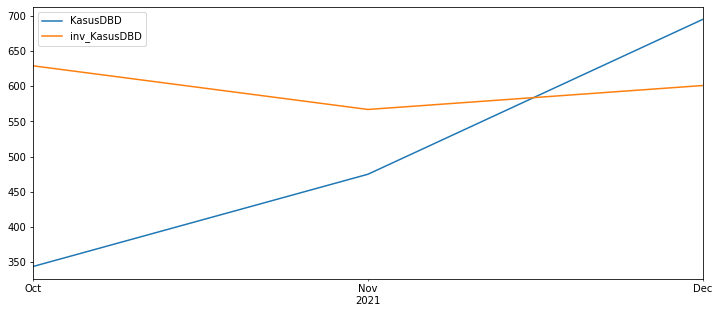

In [138]:
test_vs_prediction[['KasusDBD','inv_KasusDBD']].plot(figsize=(12,5))

<AxesSubplot:>

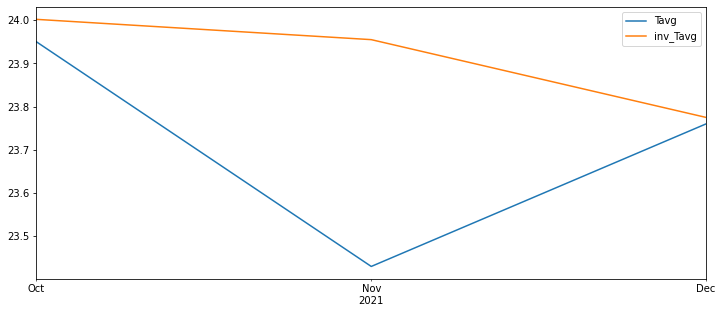

In [139]:
test_vs_prediction[['Tavg','inv_Tavg']].plot(figsize=(12,5))

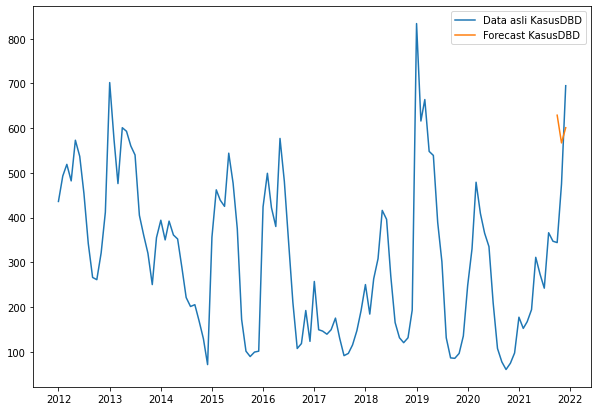

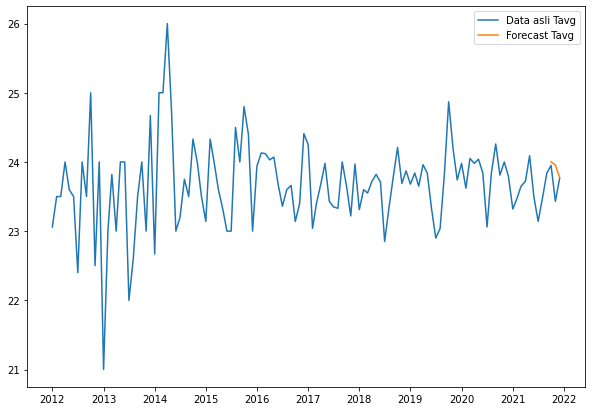

In [142]:
for i in ['KasusDBD','Tavg']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(dataTA[str(i)], label='Data asli '+str(i))
    plt.plot(test_vs_prediction['inv_'+str(i)], label='Forecast '+str(i))
    plt.legend(loc='best')
    plt.show()